<h2>Algorithm X</h2>
<ol> 
    <li> Construct a matrix, A with <i>n</i> columns, where <i>n</i> is the sum of the number of elements used to cover the field and the number of cells to be covered - this ensures we have a way of identifying which elements cover which fields - this is not 100% necessary if we're using a single shape only. In our case we do not need to worry about the exact coverage of the elements columns - we are going to use the same shape more than one - only one shape in the most extreme cases.</li>
    <li> Construct rows use to represent all possible valid positions of the covering elements - 1 in the column identifying the piece and 1s in all the columns identifying cells covered by given element.</li>
    <li> Look for solutions that have exaclty one 1 in each column, i.e. each cell is covered by one element only and there are no overlapping elements.</li>
    <ol> 
        <li>If matrix A is empty (all 0s) - problem solved, terminate successfully</li>
        <li>Deterministically choose column, c - chooce column which has the fewest 1s, leading to the lowest number of branches in laters stages of the algorithm</li>
        <li>Nondeterministically chooise a row, r such that A[r, c] = 1 - this is the place where the algorithm splits into small subalgorithms</li>
        <li>Include r in the partial solution</li>
        <li>Choose all the columns, j such that A[r, j] = 1 - this selects columns that are solved by the currently selected row, r
        <li>Select all the rows, i for each of the columns, j such that A[i, j] = 1 - this selects rows that contain 1s in columns already solved by row r.
        <li>Delete all the columns j and rows i (this includes the deterministically chosen row, r in the step above) - this removes columns that have already been solved by row r and rows that cover the columns already covered by row r - we make sure we cover each cell only once.
        <li>Repeat the algorithm recursively on the reduced matrix A (with columns and rows removed in the step above) - go back to the first step with checking whether the remaining matrix is empty.
    </ol>
</ol>

<h2>To-do list</h2>
<ul>
    <li> Algorithm stops after the first solution is found - we will have a case where at least tens of solutions are valid and don't want to go through all of them
</ul>

In [1]:
%matplotlib inline

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.signal as ssignal

In [173]:
class Tiling:
    def __init__(self, _beampositions = np.zeros((1,1)), _debug=False, _random = False, _usebeams=396):
        self.debug = _debug
        self.usebeams = _usebeams
        self.beampositions = _beampositions
        self.nobeams = len(self.beampositions)
        self.random = _random
        self.solution = []
        self.coveragelines = 0
        
        if self.random:
            #self.columns = random.randrange(50,100)
            #self.rows = random.randrange(50, 100)
            
            self.columns = 406
            self.rows = 812
            
            print("Random array with %i rows and %i columns" % (self.rows, self.columns))
    
        ### This is just a quick fix - will need a method for setting the shape(s) ###
        self.shape = np.zeros((6, 2))
        self.shape[0, :] = np.array((0, 0))
        self.shape[1, :] = np.array((-1, -1))
        self.shape[2, :] = np.array((1, -1))
        self.shape[3, :] = np.array((0, -2))
        self.shape[4, :] = np.array((-1, -3))
        self.shape[5, :] = np.array((1, -3))
        
        self.NormaliseBeams()
    
    def NormaliseBeams(self):
        print("Preparing the beam information...")

        ### The transformations described belowe will not affect the general results ###
        ### We have to worry about the relative placement of the beams and not their absolute positions ### 
        ### Need to rotate the beam positions, so that the 'principal axis' is parallel to the x-axis ###
        ### This assumes that the beamforming algorithm will not change the way beam positions are filled ###
        centralbeam = self.beampositions[0, :]
        nextbeam = self.beampositions[1, :]
        
        ### This creates an appropriate rotation matrix - we rotate by a negative value of current angle ###
        angle = -1.0 * np.arctan(nextbeam[1] / nextbeam[0])
        rotation = np.array(((np.cos(angle), -np.sin(angle)), (np.sin(angle), np.cos(angle))))
    
        ### This is where the beams are rotated so that the principal axis of the algorithm is parallel to x ###
        ### We use the transpose of rotational matrix as we use row * matrix instead of matrix * column ###
        beamsrotated = np.apply_along_axis(np.matmul, 1, self.beampositions, np.transpose(rotation))
        
        
        ### Need to normalise the distances between the beams - each columns is offset by 1 and each row is offset by 1 ###
        ### Get the x positions for all the beams in the first row ###
        ### Use average separation between the beams there to take minor differences due to rounding into account ###
        ### Just interested in x position - y should be 0 in all cases and pick one side only ###
        horizontal = np.where(beamsrotated[:, 1] == 0.0)[0]
        horizontaleven = horizontal[(np.mod(horizontal, 2) == 0) & (horizontal != 0)]
        
        ### Final division by 2 make sure we take obtain the lowest shift in x ###
        ### The offset in x-coordinate for neighbouring rows is half the separation between beams in the same row ###
        minhordist = np.sum(beamsrotated[horizontaleven, 0] / (horizontaleven / 2)) / len(horizontaleven) / 2.0
        
        ### First we normalise in the horizontal direction - makes finding vertical direction points easier ###
        normalisation = np.array((1.0 / minhordist, 1))

        ### np.rint() rounds to the nearest integer - that should properly fix any small rounding errors ###
        seminormalised = np.rint(np.apply_along_axis(np.multiply, 1, beamsrotated, normalisation))
        seminormalised[:, 1] = beamsrotated[:, 1]
    
        ### Same logic as above for the vertical direction ###
        vertical = np.where(seminormalised[:, 0] == 0.0)[0]
        verticalpositives = seminormalised[vertical[seminormalised[vertical, 1] > 0], 1]
        minverdist = np.sum(seminormalised[vertical[seminormalised[vertical, 1] > 0], 1] / (np.arange(len(verticalpositives)) + 1)) / len(verticalpositives) / 2

        normalisation = np.array((1.0, 1.0 / minverdist))

        self.normalisedbeams = np.rint(np.apply_along_axis(np.multiply, 1, seminormalised, normalisation))
        
        if self.debug:
            print(self.normalisedbeams[:int(0.1 * len(self.normalisedbeams)), :])
            fig = plt.figure(figsize=(15,15))
            ax = fig.gca()

            ax.scatter(self.normalisedbeams[:, 0], self.normalisedbeams[:, 1], color='skyblue')

            ax.axhline(0.0, color='black', linewidth=1.0)
            ax.axvline(0.0, color='black', linewidth=1.0)

    def PlotBeams(self):
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
    
    def PrepareCoverage(self, debug=False):
        print("Preparing the coverage matrix for ...")
        
        if self.random:
            self.coverage = np.zeros((self.rows, self.columns))
            for row in np.arange(self.rows):
                for column in np.arange(self.columns):
                    self.coverage[row, column] = random.choice([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
    
        positionslist = self.normalisedbeams.tolist()
        tmpcoverage = []
        coverageline = [0] * self.nobeams

        # Technically min and max values should be the same for the same dimension - we're working with an ellipse
        # This can however change in the future when we start using more 'exotic' beam positions
        minhor = min(self.normalisedbeams[:, 0])
        maxhor = max(self.normalisedbeams[:, 0])
        minver = min(self.normalisedbeams[:, 1])
        maxver = max(self.normalisedbeams[:, 1])

        self.shape[:, 0] = self.shape[:, 0] - abs(minhor)
        self.shape[:, 1] = self.shape[:, 1] + maxver

        if self.debug:
            print("Beams extrema: horizontal: %i, %i; vertical: %i, %i" % (minhor, maxhor, minver, maxver))
            print("Shape starting position: ", self.shape)

            fig = plt.figure(figsize=(15,15))
            ax = fig.gca()

            ax.scatter(self.normalisedbeams[:, 0], self.normalisedbeams[:, 1], color='skyblue')
            ax.scatter(self.shape[:, 0], self.shape[:, 1], color='orchid', alpha=0.25)

        positionsoverlap = []

        for currentver in np.arange(maxver + abs(minver)):

            for currenthor in np.arange(maxhor + abs(minhor)):
                overlapping = 0

                for shapepoint in np.arange(len(self.shape)):
                    if self.shape[shapepoint].tolist() in positionslist:
                        overlapping = overlapping + 1
                        positionsoverlap.append(np.where((self.shape[shapepoint, 0] == self.normalisedbeams[:, 0]) & (self.shape[shapepoint, 1] == self.normalisedbeams[:, 1])))

                if overlapping == len(self.shape):
                    tmpcoverage.append(coverageline)
                    if self.debug:
                        print("Overlap: ", positionsoverlap)
                    for index in positionsoverlap:
                        ### This indexing is starting to feel too much like a guesswork ###
                        ### TODO: Why do I need double indexing? ###
                        tmpcoverage[self.coveragelines][index[0][0]] = 1
                        
                    self.coveragelines = self.coveragelines + 1
                    
                    if debug:
                        print(positionsoverlap)
                        ax.scatter(self.shape[:, 0], self.shape[:, 1], color='orange', alpha=0.25)

                self.shape[:, 0] = self.shape[:, 0] + 1
                positionsoverlap = []
                
            self.shape[:, 0] = self.shape[:, 0] - (maxhor + abs(minhor))
            self.shape[:, 1] = self.shape[:, 1] - 1

        self.coverage = np.array(tmpcoverage)
                    
        if self.debug:
            print("Coverage array shape: ", self.coverage.shape)
        
        self.columnids = np.arange(self.coverage.shape[1])
        self.rowids = np.arange(self.coverage.shape[0])
    
    def SetCoverage(self, _coverage):
        
        self.coverage = np.copy(_coverage)
        self.columnids = np.arange(self.coverage.shape[1])
        self.rowids = np.arange(self.coverage.shape[0])
    
    def ShowCoverage(self):
        print(self.coverage[0])
        
        fig = plt.figure(figsize=(20, 20))
        ax = fig.gca()
        
        cmap = colors.ListedColormap(['white', 'black'])
        
        self.coverageimage = ax.imshow(self.coverage, aspect='equal', interpolation='none', cmap=cmap)
        ax.set_xlim(0, 50)
        ax.set_ylim(0, 50)
    ### REMEMBER TO SKIP THE FIRST COLUMN IN ALL CALCULATIONS - IT CONTAINS THE ORIGINAL ROW INDICES!! ###
    
    def ShowSolution(self):
        
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
        cmap = colors.ListedColormap(['white', 'black'])
        ax.imshow(self.coverage[sorted(self.solution), :], aspect='equal', interpolation='none', cmap=cmap)
        ax.set_yticks(np.arange(len(self.solution)))
        ax.set_yticklabels(sorted(self.solution))
    
    def Solve(self, array, columnids, rowids):
        print("Finding the optimum tiling...")
        
        print("Current partial solution: ", self.solution)
        
        if columnids.size != 0:
            print("Array is not empty...")
            
            columnsum = np.sum(array, axis=0)
            
            if 0 in columnsum:
                # This violates part C of algorithm - A[r,c] should have 1 in it and not 0
                print("Solution does not exist!")
                print("\n\n")

            else:

                mincolumns = np.where(columnsum == np.min(columnsum))[0]
                choosecolumn = mincolumns[0]
                rows = np.where(array[:, choosecolumn] == 1)[0]
                
                for row in rows:

                    print("Working with row ", rowids[row])

                    self.solution.append(rowids[row])

                    solvedcolumns = np.where(array[row, :] == 1)[0]
                    print("Colums solved ", solvedcolumns)

                    solvingrows = np.unique(np.where(array[:, solvedcolumns] == 1)[0])
                    print("Rows that solve these columns ", solvingrows)

                    reduced = np.delete(np.delete(array, solvedcolumns, axis=1), solvingrows, axis=0)
                    reducedcolumnids = np.delete(columnids, solvedcolumns, axis=0)
                    reducedrowids = np.delete(rowids, solvingrows, axis=0)

                    print("Reduced array ", reduced)
                    self.Solve(reduced, reducedcolumnids.copy(), reducedrowids.copy())

                    if self.solution:
                        self.solution.pop()

        else:
            print("Coverage array is empty. We have a valid solution!")
            print("Solving rows ", self.solution)
            print("\n")
            print("Solution: ")
            self.ShowSolution()

In [174]:
testarray = np.zeros((5, 8))

testarray.shape[1]

for row in np.arange(testarray.shape[0]):
    for column in np.arange(testarray.shape[1]):
        testarray[row, column] = random.choice([0, 0, 1])

print(testarray)

[[0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [175]:


### 0 3 4 is a solution
#'''
testarray = np.zeros((6, 7))
testarray[0, :] = [0, 0, 1, 0, 1, 1, 0]
testarray[1, :] = [1, 0, 0, 1, 0, 0, 1]
testarray[2, :] = [0, 1, 1, 0, 0, 1, 0]
testarray[3, :] = [1, 0, 0, 1, 0, 0, 0]
testarray[4, :] = [0, 1, 0, 0, 0, 0, 1]
testarray[5, :] = [0, 0, 0, 1, 1, 0, 1]
#'''

### 1 3 5 is a solution

'''
testarray = np.zeros((6, 7))
testarray[0, :] = [1, 0, 0, 1, 0, 0, 1]
testarray[1, :] = [1, 0, 0, 1, 0, 0, 0]
testarray[2, :] = [0, 0, 0, 1, 1, 0, 1]
testarray[3, :] = [0, 0, 1, 0, 1, 1, 0]
testarray[4, :] = [0, 1, 1, 0, 0, 1, 1]
testarray[5, :] = [0, 1, 0, 0, 0, 0, 1]
'''
#testarray[:, 0] = np.arange(testarray.shape[0])
#testarray[0, :] = np.arange(testarray.shape[1])

print(testarray)


[[0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0. 1.]]


In [176]:
testbeams = np.loadtxt('test_beams.dat', delimiter='\t')
tiling = Tiling(_beampositions=testbeams, _debug=False, _random=False)
tiling.PrepareCoverage()
#tiling.SetCoverage(testarray)
tiling.ShowCoverage()


Preparing the beam information...
Preparing the coverage matrix for ...


IndexError: list index out of range

Finding the optimum tiling...
Current partial solution:  []
Array is not empty...
Working with row  1
Colums solved  [0 3 6]
Rows that solve these columns  [1 3 4 5]
Reduced array  [[0. 1. 1. 1.]
 [1. 1. 0. 1.]]
Finding the optimum tiling...
Current partial solution:  [1]
Array is not empty...
Working with row  2
Colums solved  [0 1 3]
Rows that solve these columns  [0 1]
Reduced array  []
Finding the optimum tiling...
Current partial solution:  [1, 2]
Array is not empty...
Solution does not exist!



Working with row  3
Colums solved  [0 3]
Rows that solve these columns  [1 3 5]
Reduced array  [[0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1.]]
Finding the optimum tiling...
Current partial solution:  [3]
Array is not empty...
Working with row  0
Colums solved  [1 2 3]
Rows that solve these columns  [0 1]
Reduced array  [[1. 1.]]
Finding the optimum tiling...
Current partial solution:  [3, 0]
Array is not empty...
Working with row  4
Colums solved  [0 1]
Rows that solve these column

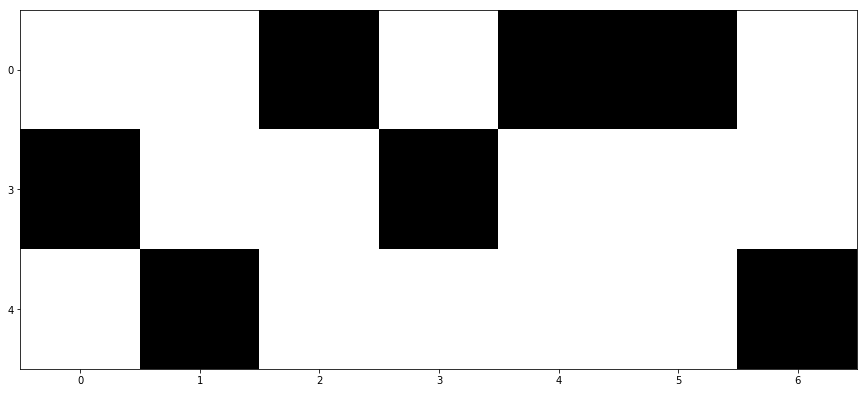

In [44]:
tiling.Solve(tiling.coverage, tiling.columnids, tiling.rowids)

In [8]:
column_sums = np.sum(testarray[:, 1:], axis=0)
print(column_sums)
columns = np.where(column_sums == np.amin(column_sums))[0]
print(columns)
print(columns[0])

rows = np.where(testarray[:, columns[0] + 1] == 1)[0]

print(rows)

for row in rows:
    print("Looking at row %d now..." % row)
    solvedcolumns = np.where(testarray[row, 1:] == 1)[0] + 1
    print("Solved columns", solvedcolumns)

    solvingrows = np.unique(np.where(testarray[:, solvedcolumns] == 1)[0])
    print("Solving rows", solvingrows)
    
    tmp = np.delete(testarray, solvedcolumns, axis=1)
    tmp2 = np.delete(tmp, solvingrows, axis=0)
    
    solution = np.delete(np.delete(testarray, solvedcolumns, axis=1), solvingrows, axis=0)
    
print(tmp2)
print(solution)
if 0 in column_sums:
    print("Solution does not exist")

[2. 2. 3. 2. 2. 3.]
[0 1 3 4]
0
[2 4]
Looking at row 2 now...
Solved columns [1 2 5]
Solving rows [0 2 4]
Looking at row 4 now...
Solved columns [1 6]
Solving rows [1 2 4 5]
[[0. 1. 0. 1. 1.]
 [1. 0. 1. 0. 0.]]
[[0. 1. 0. 1. 1.]
 [1. 0. 1. 0. 0.]]


In [9]:
testarray = np.ones((2,3))
np.sum(testarray, axis=0)

array([2., 2., 2.])

In [10]:
np.sum(np.delete(testarray, [0, 1], axis=0), axis=0)

array([0., 0., 0.])

In [11]:
mylist = [0, 1, 2, 3]
print(mylist)
mylist.append(4)
print(mylist)
mylist.pop()
print(mylist)

[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3]


0.0035007439685491603
[0.00700149 0.00700149 0.00700149 0.00700149 0.00700149 0.00700149
 0.00700149 0.00700149 0.00700149]
[  0  41  54  95 108 145 158 195 208 245 256 287 298 329 338 363 370 389
 394]
[0.00700149 0.01400298 0.02100446 0.02800595 0.03500744 0.04200893
 0.04901042 0.0560119  0.06301339]


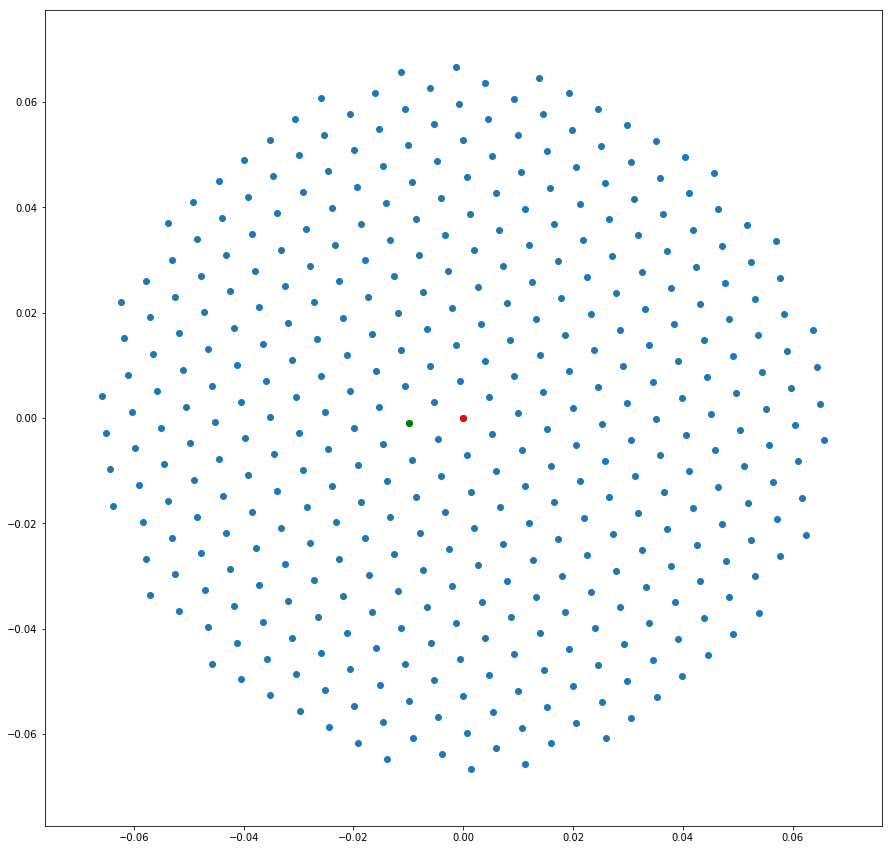

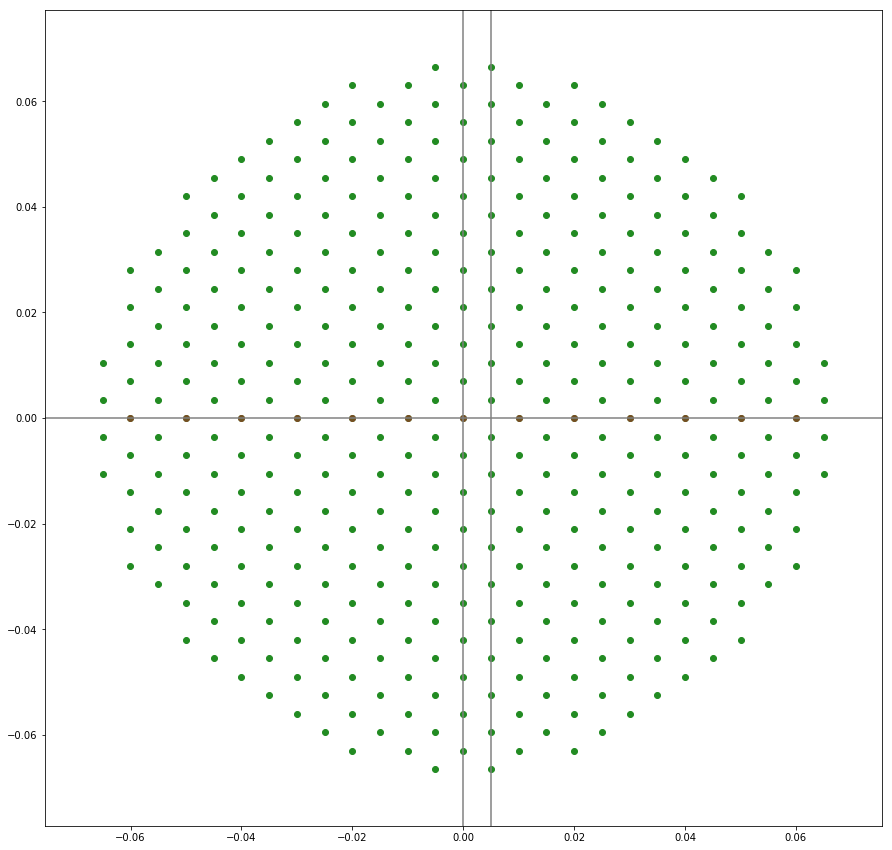

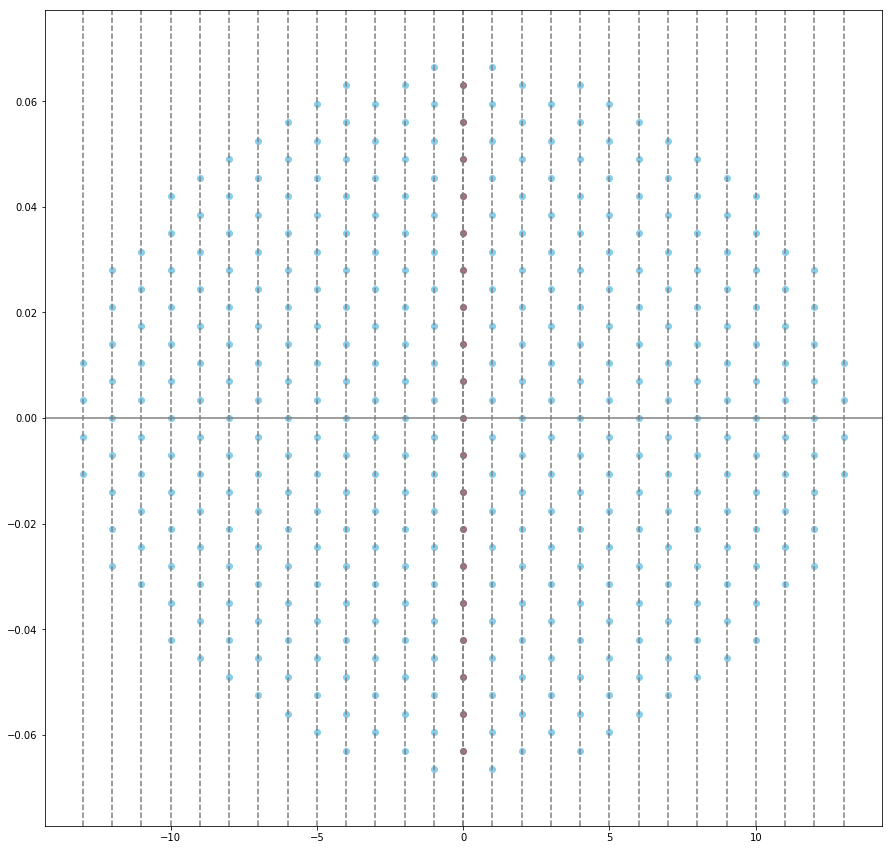

In [13]:
### !!! CHANGE FOR EVERY test_beams.dat FILE !!! ###
# Current angle printed out by the software: -174.503107

testbeams = np.loadtxt('test_beams.dat', delimiter='\t')

fig = plt.figure(figsize=(15,15))
ax = fig.gca()

ax.scatter(testbeams[:, 0], testbeams[:, 1])
ax.scatter(testbeams[0, 0], testbeams[0, 1], color='red')
ax.scatter(testbeams[1, 0], testbeams[1, 1], color='green')

centralbeam = testbeams[0, :]
nextbeam = testbeams[1, :]

### The transformations described belowe will not affect the general results ###
### We have to worry about the relative placement of the beams and not their absolute positions ### 
### Need to rotate the beam positions, so that the 'principal axis' is parallel to the x-axis ###

angle = np.rad2deg(np.arctan(nextbeam[1] / nextbeam[0]))
beamsign = np.sign(nextbeam[0])


angle = -1.0 * np.arctan(nextbeam[1] / nextbeam[0])
rotation = np.array(((np.cos(angle), -np.sin(angle)), (np.sin(angle), np.cos(angle))))

rotated = np.matmul(rotation, testbeams[1, :].reshape(2, 1))
#ax.scatter(rotated[0], rotated[1], color='darkmagenta')

beamsrotated = np.apply_along_axis(np.matmul, 1, testbeams, np.transpose(rotation))
fig = plt.figure(figsize=(15,15))
ax = fig.gca()

ax.scatter(beamsrotated[:, 0], beamsrotated[:, 1], color='forestgreen')
ax.axhline(0.0, color='grey')
ax.axvline(0.0, color='grey')

### Need to normalise the distances between the beams - each columns is offset by 1 and each row is offset by 1 ###
### Get the x positions for all the beams in the first row ###
### Use average separation between the beams there to take minor differences due to rounding into account ###

## This implementation will not find all of them in case there are some rounding error problems ###
horizontal = np.where(beamsrotated[:, 1] == 0.0)[0]
#print(horizontal)
horizontaleven = horizontal[(np.mod(horizontal, 2) == 0) & (horizontal != 0)]
#print(horizontaleven)
#print(beamsrotated[horizontaleven, 0])
#print(beamsrotated[horizontaleven, 0] / (horizontaleven / 2))

# Final division by 2 make sure we take optain the lowest shift in x
# The difference in x-coordinate for neighbouring rows is half the separation between beams in the same row
minhordist = np.sum(beamsrotated[horizontaleven, 0] / (horizontaleven / 2)) / len(horizontaleven) / 2.0
#print(minhordist)

ax.scatter(beamsrotated[horizontal, 0], beamsrotated[horizontal, 1], color='firebrick', alpha=0.5)
ax.axvline(minhordist, color='grey')

normalisation = np.array((1.0 / minhordist, 1))

seminormalised = np.rint(np.apply_along_axis(np.multiply, 1, beamsrotated, normalisation))
seminormalised[:, 1] = beamsrotated[:, 1]


fig = plt.figure(figsize=(15,15))
ax = fig.gca()

vertical = np.where(seminormalised[:, 0] == 0.0)[0]
verticalpositives = seminormalised[vertical[seminormalised[vertical, 1] > 0], 1]

minverdist = np.sum(seminormalised[vertical[seminormalised[vertical, 1] > 0], 1] / (np.arange(len(verticalpositives)) + 1)) / len(verticalpositives) / 2

print(minverdist)

print(verticalpositives / (np.arange(len(verticalpositives)) + 1))

print(vertical)
print(verticalpositives)

ax.scatter(seminormalised[:, 0], seminormalised[:, 1], color='skyblue')
ax.scatter(seminormalised[vertical, 0], seminormalised[vertical, 1], color='firebrick', alpha=0.5)

ax.axhline(0.0, color='grey')

for column in np.arange(14):
    ax.axvline(column, color='grey', linestyle='--')
    ax.axvline(-1.0 * column, color='grey', linestyle='--')
    
normalisation = np.array((1.0, 1.0 / minverdist))

fullynormalised = np.rint(np.apply_along_axis(np.multiply, 1, seminormalised, normalisation))

In [14]:
shape = np.zeros((6, 2))
shape[0, :] = np.array((0, 0))
shape[1, :] = np.array((-1, -1))
shape[2, :] = np.array((1, -1))
shape[3, :] = np.array((0, -2))
shape[4, :] = np.array((-1, -3))
shape[5, :] = np.array((1, -3))

shape2 = np.zeros((6, 2))
shape2[0, :] = np.array((0, 0))
shape2[1, :] = np.array((-1, -1))
shape2[2, :] = np.array((1, -1))
shape2[3, :] = np.array((-2, -2))
shape2[4, :] = np.array((0, -2))
shape2[5, :] = np.array((-1, -3))

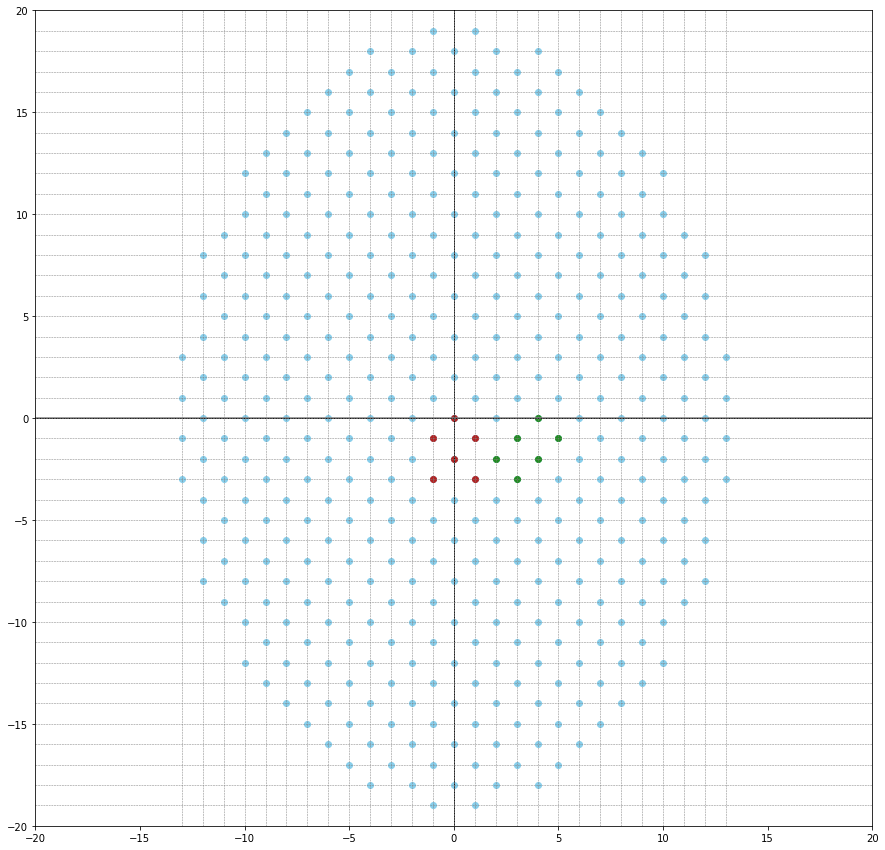

In [15]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()

ax.scatter(fullynormalised[:, 0], fullynormalised[:, 1], color='skyblue')

ax.axhline(0.0, color='grey')
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

ax.scatter(shape[:, 0], shape[:, 1], color='firebrick')
ax.scatter(shape2[:, 0] + 4, shape2[:, 1], color='forestgreen')

ax.axhline(0.0, color='black', linewidth=1.0)
ax.axvline(0.0, color='black', linewidth=1.0)

for column in np.arange(14):
    ax.axvline(column, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(-1.0 * column, color='grey', linestyle='--', linewidth=0.5)

for row in np.arange(20):
    ax.axhline(row, color='grey', linestyle='--', linewidth=0.5)
    ax.axhline(-1.0 * row, color='grey', linestyle='--', linewidth=0.5)
    


Beams extrema: horizontal: -13, 13; vertical: -19, 19
Shape starting position:  [[-13.  19.]
 [-14.  18.]
 [-12.  18.]
 [-13.  17.]
 [-14.  16.]
 [-12.  16.]]
Overlap:  [(array([401]),), (array([395]),), (array([394]),), (array([383]),), (array([371]),), (array([370]),)]
(array([401]),) 401
(array([395]),) 395
(array([394]),) 394
(array([383]),) 383
(array([371]),) 371
(array([370]),) 370
Overlap:  [(array([402]),), (array([394]),), (array([396]),), (array([384]),), (array([370]),), (array([372]),)]
(array([402]),) 402
(array([394]),) 394
(array([396]),) 396
(array([384]),) 384
(array([370]),) 370
(array([372]),) 372
26
Overlap:  [(array([397]),), (array([387]),), (array([385]),), (array([373]),), (array([359]),), (array([357]),)]
(array([397]),) 397
(array([387]),) 387
(array([385]),) 385
(array([373]),) 373
(array([359]),) 359
(array([357]),) 357
Overlap:  [(array([395]),), (array([385]),), (array([383]),), (array([371]),), (array([357]),), (array([355]),)]
(array([395]),) 395
(array

Overlap:  [(array([321]),), (array([301]),), (array([299]),), (array([279]),), (array([259]),), (array([257]),)]
(array([321]),) 321
(array([301]),) 301
(array([299]),) 299
(array([279]),) 279
(array([259]),) 259
(array([257]),) 257
Overlap:  [(array([319]),), (array([299]),), (array([298]),), (array([277]),), (array([257]),), (array([256]),)]
(array([319]),) 319
(array([299]),) 299
(array([298]),) 298
(array([277]),) 277
(array([257]),) 257
(array([256]),) 256
Overlap:  [(array([320]),), (array([298]),), (array([300]),), (array([278]),), (array([256]),), (array([258]),)]
(array([320]),) 320
(array([298]),) 298
(array([300]),) 300
(array([278]),) 278
(array([256]),) 256
(array([258]),) 258
Overlap:  [(array([322]),), (array([300]),), (array([302]),), (array([280]),), (array([258]),), (array([260]),)]
(array([322]),) 322
(array([300]),) 300
(array([302]),) 302
(array([280]),) 280
(array([258]),) 258
(array([260]),) 260
Overlap:  [(array([324]),), (array([302]),), (array([304]),), (array

Overlap:  [(array([215]),), (array([191]),), (array([189]),), (array([165]),), (array([141]),), (array([139]),)]
(array([215]),) 215
(array([191]),) 191
(array([189]),) 189
(array([165]),) 165
(array([141]),) 141
(array([139]),) 139
Overlap:  [(array([213]),), (array([189]),), (array([187]),), (array([163]),), (array([139]),), (array([137]),)]
(array([213]),) 213
(array([189]),) 189
(array([187]),) 187
(array([163]),) 163
(array([139]),) 139
(array([137]),) 137
Overlap:  [(array([211]),), (array([187]),), (array([185]),), (array([161]),), (array([137]),), (array([135]),)]
(array([211]),) 211
(array([187]),) 187
(array([185]),) 185
(array([161]),) 161
(array([137]),) 137
(array([135]),) 135
Overlap:  [(array([209]),), (array([185]),), (array([183]),), (array([159]),), (array([135]),), (array([133]),)]
(array([209]),) 209
(array([185]),) 185
(array([183]),) 183
(array([159]),) 159
(array([135]),) 135
(array([133]),) 133
Overlap:  [(array([208]),), (array([183]),), (array([184]),), (array

Overlap:  [(array([108]),), (array([81]),), (array([82]),), (array([54]),), (array([27]),), (array([28]),)]
(array([108]),) 108
(array([81]),) 81
(array([82]),) 82
(array([54]),) 54
(array([27]),) 27
(array([28]),) 28
Overlap:  [(array([110]),), (array([82]),), (array([84]),), (array([56]),), (array([28]),), (array([30]),)]
(array([110]),) 110
(array([82]),) 82
(array([84]),) 84
(array([56]),) 56
(array([28]),) 28
(array([30]),) 30
Overlap:  [(array([112]),), (array([84]),), (array([86]),), (array([58]),), (array([30]),), (array([32]),)]
(array([112]),) 112
(array([84]),) 84
(array([86]),) 86
(array([58]),) 58
(array([30]),) 30
(array([32]),) 32
Overlap:  [(array([114]),), (array([86]),), (array([88]),), (array([60]),), (array([32]),), (array([34]),)]
(array([114]),) 114
(array([86]),) 86
(array([88]),) 88
(array([60]),) 60
(array([32]),) 32
(array([34]),) 34
Overlap:  [(array([116]),), (array([88]),), (array([90]),), (array([62]),), (array([34]),), (array([36]),)]
(array([116]),) 116


Overlap:  [(array([7]),), (array([21]),), (array([19]),), (array([48]),), (array([75]),), (array([73]),)]
(array([7]),) 7
(array([21]),) 21
(array([19]),) 19
(array([48]),) 48
(array([75]),) 75
(array([73]),) 73
Overlap:  [(array([5]),), (array([19]),), (array([17]),), (array([46]),), (array([73]),), (array([71]),)]
(array([5]),) 5
(array([19]),) 19
(array([17]),) 17
(array([46]),) 46
(array([73]),) 73
(array([71]),) 71
Overlap:  [(array([3]),), (array([17]),), (array([15]),), (array([44]),), (array([71]),), (array([69]),)]
(array([3]),) 3
(array([17]),) 17
(array([15]),) 15
(array([44]),) 44
(array([71]),) 71
(array([69]),) 69
Overlap:  [(array([1]),), (array([15]),), (array([13]),), (array([42]),), (array([69]),), (array([67]),)]
(array([1]),) 1
(array([15]),) 15
(array([13]),) 13
(array([42]),) 42
(array([69]),) 69
(array([67]),) 67
Overlap:  [(array([0]),), (array([13]),), (array([14]),), (array([41]),), (array([67]),), (array([68]),)]
(array([0]),) 0
(array([13]),) 13
(array([14])

Overlap:  [(array([148]),), (array([175]),), (array([173]),), (array([198]),), (array([225]),), (array([223]),)]
(array([148]),) 148
(array([175]),) 175
(array([173]),) 173
(array([198]),) 198
(array([225]),) 225
(array([223]),) 223
Overlap:  [(array([146]),), (array([173]),), (array([171]),), (array([196]),), (array([223]),), (array([221]),)]
(array([146]),) 146
(array([173]),) 173
(array([171]),) 171
(array([196]),) 196
(array([223]),) 223
(array([221]),) 221
Overlap:  [(array([145]),), (array([171]),), (array([172]),), (array([195]),), (array([221]),), (array([222]),)]
(array([145]),) 145
(array([171]),) 171
(array([172]),) 172
(array([195]),) 195
(array([221]),) 221
(array([222]),) 222
Overlap:  [(array([147]),), (array([172]),), (array([174]),), (array([197]),), (array([222]),), (array([224]),)]
(array([147]),) 147
(array([172]),) 172
(array([174]),) 174
(array([197]),) 197
(array([222]),) 222
(array([224]),) 224
Overlap:  [(array([149]),), (array([174]),), (array([176]),), (array

26
Overlap:  [(array([363]),), (array([377]),), (array([378]),), (array([389]),), (array([399]),), (array([400]),)]
(array([363]),) 363
(array([377]),) 377
(array([378]),) 378
(array([389]),) 389
(array([399]),) 399
(array([400]),) 400
26
26
26
True
Yes
[13]


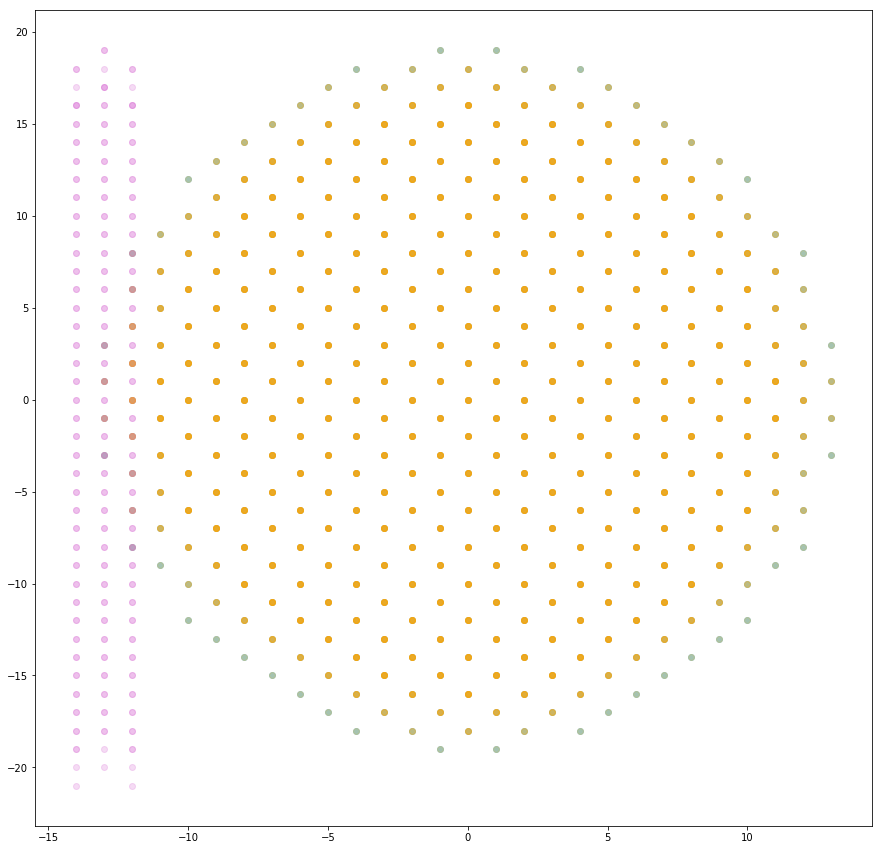

In [146]:
def CheckShape(shape, positions, debug=True):
    
    coverage = [0] * len(positions)
    
    positionslist = positions.tolist()
    
    # Technically min and max values should be the same for the same dimension - we're working with an ellipse
    # This can however change in the future when we start using more 'exotic' beam positions
    minhor = min(positions[:, 0])
    maxhor = max(positions[:, 0])
    minver = min(positions[:, 1])
    maxver = max(positions[:, 1])
    
    shape[:, 0] = shape[:, 0] - abs(minhor)
    shape[:, 1] = shape[:, 1] + maxver
    
    if debug:
        print("Beams extrema: horizontal: %i, %i; vertical: %i, %i" % (minhor, maxhor, minver, maxver))
        print("Shape starting position: ", shape)
        
        fig = plt.figure(figsize=(15,15))
        ax = fig.gca()
        
        ax.scatter(positions[:, 0], positions[:, 1], color='skyblue')
        ax.scatter(shape[:, 0], shape[:, 1], color='orchid', alpha=0.25)
    
    positionsoverlap = []
    
    for currentver in np.arange(maxver + abs(minver)):
    
        moved = 0
    
        for currenthor in np.arange(maxhor + abs(minhor)):
            overlapping = 0

            for shapepoint in np.arange(len(shape)):
                if shape[shapepoint].tolist() in positionslist:
                    #print("Overlap at", shape[shapepoint])
                    overlapping = overlapping + 1
                    positionsoverlap.append(np.where((shape[shapepoint, 0] == fullynormalised[:, 0]) & (shape[shapepoint, 1] == fullynormalised[:, 1])))

            if overlapping == len(shape):
                #print("Full overlap")
                print("Overlap: ", positionsoverlap)
                for index in positionsoverlap:
                    print(index, index[0][0])
                ax.scatter(shape[:, 0], shape[:, 1], color='orange', alpha=0.25)

            shape[:, 0] = shape[:, 0] + 1
            moved = moved + 1
            positionsoverlap = []
        
        print(moved)
        shape[:, 0] = shape[:, 0] - (maxhor + abs(minhor))
        ax.scatter(shape[:, 0], shape[:, 1], color='orchid', alpha=0.25)
        shape[:, 1] = shape[:, 1] - 1

    
minhor = min(fullynormalised[:, 0])

CheckShape(np.copy(shape), fullynormalised)

print(shape[0] in fullynormalised)

if shape[0] in fullynormalised:
    print("Yes")
    print(np.where((shape[1, 0] == fullynormalised[:, 0]) & (shape[1, 1] == fullynormalised[:, 1]))[0])

    
#np.where((shape[0, 0] == fullynormalised[:, 0]) & (shape[0, 1] == fullynormalised[:, 1]))
#np.where(shape == fullynormalised)

In [76]:
coverline = [0] * 406
coverage = []
coverage.append(list(coverline))
indices = [0, 1, 2, 6, 3]
print(coverage)
for index in indices:
    coverage[0][index] = 1
coverage.append(list(coverline))
print(coverage)
covarray = np.array(coverage)
print(covarray)
print(covarray.shape)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [72]:
arr = []
arr.append([1,2,3])
print(arr)
print(arr[0][0])
arr.append([4,5,6])
np_arr = np.array(arr)
print(arr)

[[1, 2, 3]]
1
[[1, 2, 3], [4, 5, 6]]
